In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import mglearn
%matplotlib inline
from sklearn.model_selection import train_test_split
import os

/Users/okuharasho/.pyenv/versions/3.6.5/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/Users/okuharasho/.pyenv/versions/3.6.5/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# テキストデータの処理



## 文字列として表現されているデータのタイプ

テキストデータを機械学習向けの表現に処理するステップに進む前に、よくあるテキストデータの種類について簡単に説明しよう。テキストは、データセット上は単なる文字列として表現される。しかし全ての文字列特徴量がテキストデータとして扱うべきものではない。文字列特徴量は、カテゴリ変数を表す場合もある。データの中身を見ないと文字列特徴量をどう扱うべきかわからない。文字列データには次の４つの種類がある。<br><br>
・カテゴリデータ<br>
・意味的にはカテゴリに分類できる自由に書かれた文字列<br>
・構造化された文字列<br>
・テキストデータ<br>
<br><br>
カテゴリデータは固定されたリストから得られるデータである。例として、好みの色を調査することを考えてみよう。ドロップダウンメニューから「red」「green」「blue」「yellow」「black」「white」「purple」「pink」のいずれかを選択するようになっていれば結果のデータセットにはちょうど８つの値だけが含まれるようになり、明らかにカテゴリ変数をエンコードしていることになる。このようになっているかを目視で確認し（あまりにも多種の文字列が含まれているのならば、カテゴリ変数ではない可能性が高い。）、計算機でデータセットから重複を取り除いたり、出現頻度のヒストグラムを描くなどして確認する必要がある。さらに、個々の変数が、アプリケーションにとって意味のあるカテゴリに対応しているかを確認する必要がある。

<br><br><br>

## 例題アプリケーション：映画レビューのセンチメント分析



In [2]:
! wget -nc http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz -P data

--2019-10-21 23:28:03--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: `data/aclImdb_v1.tar.gz'

aclImdb_v1.tar.gz   100%[===================>]  80.23M   245KB/s    in 6m 33s  

2019-10-21 23:34:37 (209 KB/s) - `data/aclImdb_v1.tar.gz' saved [84125825/84125825]



In [2]:
! tar xzf data/aclImdb_v1.tar.gz -C data

In [2]:
!tree -dL 2 data/aclImdb

data/aclImdb
├── test
│   ├── neg
│   └── pos
└── train
    ├── neg
    ├── pos
    └── unsup

7 directories


In [5]:
from sklearn.datasets import load_files

reviews_train = load_files("data/aclImdb/train/")
text_train, y_train = reviews_train.data, reviews_train.target
print("type of test_train: {}".format(type(text_train)))
print("length of text_train: {}".format(len(text_train)))
print("text_train[1]: \n{}".format(text_train[1]))

type of test_train: <class 'list'>
length of text_train: 25000
text_train[1]: 
b'Words can\'t describe how bad this movie is. I can\'t explain it by writing only. You have too see it for yourself to get at grip of how horrible a movie really can be. Not that I recommend you to do that. There are so many clich\xc3\xa9s, mistakes (and all other negative things you can imagine) here that will just make you cry. To start with the technical first, there are a LOT of mistakes regarding the airplane. I won\'t list them here, but just mention the coloring of the plane. They didn\'t even manage to show an airliner in the colors of a fictional airline, but instead used a 747 painted in the original Boeing livery. Very bad. The plot is stupid and has been done many times before, only much, much better. There are so many ridiculous moments here that i lost count of it really early. Also, I was on the bad guys\' side all the time in the movie, because the good guys were so stupid. "Executive Decisi

In [6]:
text_train = [doc.replace(b"<br />", b" ") for doc in text_train]

In [8]:
print("Sample per class (training) : {}".format(np.bincount(y_train)))

Sample per class (training) : [12500 12500]


In [9]:
reviews_test = load_files("data/aclImdb/test/")
text_test, y_test = reviews_test.data, reviews_test.target
print("Number of documents in test data: {}".format(len(text_test)))
print("Sample per class (test): {}".format(np.bincount(y_test)))
text_test = [doc.replace(b"<br />", b" ") for doc in text_test]

Number of documents in test data: 25000
Sample per class (test): [12500 12500]


## Bag of Words　によるテキスト表現

最も単純で効率がよく、機械学習で広く用いられているテキストデータ表現がBow表現である。この表現ではコーパスに現れた単語がテキストに合わられる回数だけが数えられる。<br>
<br>
1, トークン分割：ここの文章を単語に分割する。ホワイトペースや句読点<br>
2, ボキャブラリ構築：全ての文章に現れる全ての単語をボキャブラリとして集め、番号をつける。<br>
3, エンコード：個々の文章に対してボキャブラリの単語が現れる回数を数える。<br>
<br>
個々の単語に対して１つの特徴量を割り当てた数値表現になったということだ。<br>

## トイデータセットに対するBow

In [10]:
bards_words = ["The fool doth think he is wise,",
               "but the wise man know himself to be a fool"]

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
vect.fit(bards_words)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [13]:
print("Vocabulary size: {}".format(len(vect.vocabulary_)))
print("Vocabulary content:\n{}".format(vect.vocabulary_))

Vocabulary size: 13
Vocabulary content:
{'the': 9, 'fool': 3, 'doth': 2, 'think': 10, 'he': 4, 'is': 6, 'wise': 12, 'but': 1, 'man': 8, 'know': 7, 'himself': 5, 'to': 11, 'be': 0}


In [14]:
bag_of_words = vect.transform(bards_words)
print("bag_of_words: {}".format(repr(bag_of_words)))

bag_of_words: <2x13 sparse matrix of type '<class 'numpy.int64'>'
	with 16 stored elements in Compressed Sparse Row format>


In [15]:
print("Dense representation of bag_of_words:\n{}".format(bag_of_words.toarray()))

Dense representation of bag_of_words:
[[0 0 1 1 1 0 1 0 0 1 1 0 1]
 [1 1 0 1 0 1 0 1 1 1 0 1 1]]


In [16]:
vect = CountVectorizer().fit(text_train)
X_train = vect.transform(text_train)
print("X_train:\n{}".format(repr(X_train)))

X_train:
<25000x74849 sparse matrix of type '<class 'numpy.int64'>'
	with 3431196 stored elements in Compressed Sparse Row format>


In [17]:
feature_names = vect.get_feature_names()
print("Number of features: {}".format(len(feature_names)))
print("First 20 features:\n{}".format(feature_names[:20]))
print("Features 20010 to 20030:\n{}".format(feature_names[20010:20030]))
print("Every 2000th feature:\n{}".format(feature_names[::2000]))

Number of features: 74849
First 20 features:
['00', '000', '0000000000001', '00001', '00015', '000s', '001', '003830', '006', '007', '0079', '0080', '0083', '0093638', '00am', '00pm', '00s', '01', '01pm', '02']
Features 20010 to 20030:
['dratted', 'draub', 'draught', 'draughts', 'draughtswoman', 'draw', 'drawback', 'drawbacks', 'drawer', 'drawers', 'drawing', 'drawings', 'drawl', 'drawled', 'drawling', 'drawn', 'draws', 'draza', 'dre', 'drea']
Every 2000th feature:
['00', 'aesir', 'aquarian', 'barking', 'blustering', 'bête', 'chicanery', 'condensing', 'cunning', 'detox', 'draper', 'enshrined', 'favorit', 'freezer', 'goldman', 'hasan', 'huitieme', 'intelligible', 'kantrowitz', 'lawful', 'maars', 'megalunged', 'mostey', 'norrland', 'padilla', 'pincher', 'promisingly', 'receptionist', 'rivals', 'schnaas', 'shunning', 'sparse', 'subset', 'temptations', 'treatises', 'unproven', 'walkman', 'xylophonist']


In [18]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
scores = cross_val_score(LogisticRegression(), X_train, y_train, cv=5)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))

/Users/okuharasho/.pyenv/versions/3.6.5/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Mean cross-validation accuracy: 0.88


In [19]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

/Users/okuharasho/.pyenv/versions/3.6.5/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Best cross-validation score: 0.89
Best parameters:  {'C': 0.1}


In [20]:
X_test = vect.transform(text_test)
print("Test score: {:.2f}".format(grid.score(X_test, y_test)))

Test score: 0.88


In [21]:
vect = CountVectorizer(min_df=5).fit(text_train)
X_train = vect.transform(text_train)
print("X_train with min_df: {}".format(repr(X_train)))

X_train with min_df: <25000x27271 sparse matrix of type '<class 'numpy.int64'>'
	with 3354014 stored elements in Compressed Sparse Row format>


In [22]:
feature_names = vect.get_feature_names()

print("First 50 features:\n{}".format(feature_names[:50]))
print("Features 20010 to 20030:\n{}".format(feature_names[20010:20030]))
print("Every 700th feature:\n{}".format(feature_names[::700]))

First 50 features:
['00', '000', '007', '00s', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '100', '1000', '100th', '101', '102', '103', '104', '105', '107', '108', '10s', '10th', '11', '110', '112', '116', '117', '11th', '12', '120', '12th', '13', '135', '13th', '14', '140', '14th', '15', '150', '15th', '16', '160', '1600', '16mm', '16s', '16th']
Features 20010 to 20030:
['repentance', 'repercussions', 'repertoire', 'repetition', 'repetitions', 'repetitious', 'repetitive', 'rephrase', 'replace', 'replaced', 'replacement', 'replaces', 'replacing', 'replay', 'replayable', 'replayed', 'replaying', 'replays', 'replete', 'replica']
Every 700th feature:
['00', 'affections', 'appropriately', 'barbra', 'blurbs', 'butchered', 'cheese', 'commitment', 'courts', 'deconstructed', 'disgraceful', 'dvds', 'eschews', 'fell', 'freezer', 'goriest', 'hauser', 'hungary', 'insinuate', 'juggle', 'leering', 'maelstrom', 'messiah', 'music', 'occasional', 'parking', 'pleasantville', 'pronunciati

In [23]:
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

/Users/okuharasho/.pyenv/versions/3.6.5/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Best cross-validation score: 0.89


## ストップワード

役に立たない単語を取り除くもう一つの手法としてあまりに頻出するため役に立たない単語を捨てる方法がある。一つは言語固有のストップワードリストを作っておく方法と、頻度の高い単語を捨てる方法である。scikit-learnは英語のストップワードリストをモジュールに用意している。

In [24]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
print("Number of stop words: {}".format(len(ENGLISH_STOP_WORDS)))
print("Every 10th stopword:\n{}".format(list(ENGLISH_STOP_WORDS)[::10]))

Number of stop words: 318
Every 10th stopword:
['latter', 'whither', 'serious', 'take', 'cry', 'anyway', 'eight', 'anything', 'across', 'ourselves', 'wherever', 'done', 'fire', 'yet', 'his', 'put', 'should', 'find', 'amount', 'cannot', 'was', 'ie', 'from', 'perhaps', 'if', 'neither', 'none', 'keep', 'of', 'empty', 'under', 'always']


In [25]:
# Specifying stop_words="english" uses the built-in list.
# We could also augment it and pass our own.
vect = CountVectorizer(min_df=5, stop_words="english").fit(text_train)
X_train = vect.transform(text_train)
print("X_train with stop words:\n{}".format(repr(X_train)))

X_train with stop words:
<25000x26966 sparse matrix of type '<class 'numpy.int64'>'
	with 2149958 stored elements in Compressed Sparse Row format>


In [26]:
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

/Users/okuharasho/.pyenv/versions/3.6.5/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Best cross-validation score: 0.88


## tf-idfを用いたデータのスケール変換

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(TfidfVectorizer(min_df=5, norm=None),
                     LogisticRegression())
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10]}

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(text_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

/Users/okuharasho/.pyenv/versions/3.6.5/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Best cross-validation score: 0.89


In [28]:
vectorizer = grid.best_estimator_.named_steps["tfidfvectorizer"]
# transform the training dataset:
X_train = vectorizer.transform(text_train)
# find maximum value for each of the features over dataset:
max_value = X_train.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()
# get feature names
feature_names = np.array(vectorizer.get_feature_names())

print("Features with lowest tfidf:\n{}".format(
      feature_names[sorted_by_tfidf[:20]]))

print("Features with highest tfidf: \n{}".format(
      feature_names[sorted_by_tfidf[-20:]]))

Features with lowest tfidf:
['poignant' 'disagree' 'instantly' 'importantly' 'lacked' 'occurred'
 'currently' 'altogether' 'nearby' 'undoubtedly' 'directs' 'fond'
 'stinker' 'avoided' 'emphasis' 'commented' 'disappoint' 'realizing'
 'downhill' 'inane']
Features with highest tfidf: 
['coop' 'homer' 'dillinger' 'hackenstein' 'gadget' 'taker' 'macarthur'
 'vargas' 'jesse' 'basket' 'dominick' 'the' 'victor' 'bridget' 'victoria'
 'khouri' 'zizek' 'rob' 'timon' 'titanic']


In [29]:
sorted_by_idf = np.argsort(vectorizer.idf_)
print("Features with lowest idf:\n{}".format(
       feature_names[sorted_by_idf[:100]]))

Features with lowest idf:
['the' 'and' 'of' 'to' 'this' 'is' 'it' 'in' 'that' 'but' 'for' 'with'
 'was' 'as' 'on' 'movie' 'not' 'have' 'one' 'be' 'film' 'are' 'you' 'all'
 'at' 'an' 'by' 'so' 'from' 'like' 'who' 'they' 'there' 'if' 'his' 'out'
 'just' 'about' 'he' 'or' 'has' 'what' 'some' 'good' 'can' 'more' 'when'
 'time' 'up' 'very' 'even' 'only' 'no' 'would' 'my' 'see' 'really' 'story'
 'which' 'well' 'had' 'me' 'than' 'much' 'their' 'get' 'were' 'other'
 'been' 'do' 'most' 'don' 'her' 'also' 'into' 'first' 'made' 'how' 'great'
 'because' 'will' 'people' 'make' 'way' 'could' 'we' 'bad' 'after' 'any'
 'too' 'then' 'them' 'she' 'watch' 'think' 'acting' 'movies' 'seen' 'its'
 'him']


## モデル係数の調査

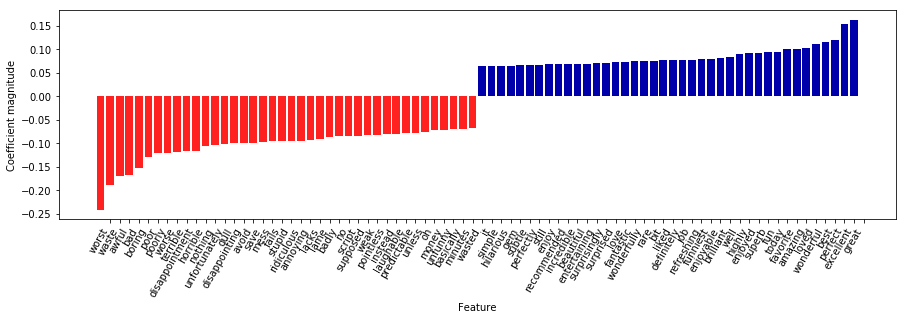

In [30]:
mglearn.tools.visualize_coefficients(
    grid.best_estimator_.named_steps["logisticregression"].coef_,
    feature_names, n_top_features=40)

## 1単語よりも大きい単位のBag-of-Words (n-グラム)

BoW表現の問題は単語の順番が完全に失われることだ。このため正反対の意味を持つセリフが全く同じ表現になってしまう。→２つもしくは３つのトークンの列を考える。

In [31]:
print("bards_words:\n{}".format(bards_words))

bards_words:
['The fool doth think he is wise,', 'but the wise man know himself to be a fool']


In [32]:
cv = CountVectorizer(ngram_range=(1, 1)).fit(bards_words)
print("Vocabulary size: {}".format(len(cv.vocabulary_)))
print("Vocabulary:\n{}".format(cv.get_feature_names()))

Vocabulary size: 13
Vocabulary:
['be', 'but', 'doth', 'fool', 'he', 'himself', 'is', 'know', 'man', 'the', 'think', 'to', 'wise']


In [33]:
cv = CountVectorizer(ngram_range=(2, 2)).fit(bards_words)
print("Vocabulary size: {}".format(len(cv.vocabulary_)))
print("Vocabulary:\n{}".format(cv.get_feature_names()))

Vocabulary size: 14
Vocabulary:
['be fool', 'but the', 'doth think', 'fool doth', 'he is', 'himself to', 'is wise', 'know himself', 'man know', 'the fool', 'the wise', 'think he', 'to be', 'wise man']


In [34]:
print("Transformed data (dense):\n{}".format(cv.transform(bards_words).toarray()))

Transformed data (dense):
[[0 0 1 1 1 0 1 0 0 1 0 1 0 0]
 [1 1 0 0 0 1 0 1 1 0 1 0 1 1]]


In [35]:
cv = CountVectorizer(ngram_range=(1, 3)).fit(bards_words)
print("Vocabulary size: {}".format(len(cv.vocabulary_)))
print("Vocabulary:\n{}".format(cv.get_feature_names()))

Vocabulary size: 39
Vocabulary:
['be', 'be fool', 'but', 'but the', 'but the wise', 'doth', 'doth think', 'doth think he', 'fool', 'fool doth', 'fool doth think', 'he', 'he is', 'he is wise', 'himself', 'himself to', 'himself to be', 'is', 'is wise', 'know', 'know himself', 'know himself to', 'man', 'man know', 'man know himself', 'the', 'the fool', 'the fool doth', 'the wise', 'the wise man', 'think', 'think he', 'think he is', 'to', 'to be', 'to be fool', 'wise', 'wise man', 'wise man know']


In [36]:
pipe = make_pipeline(TfidfVectorizer(min_df=5), LogisticRegression())
# running the grid-search takes a long time because of the
# relatively large grid and the inclusion of trigrams
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
              "tfidfvectorizer__ngram_range": [(1, 1), (1, 2), (1, 3)]}

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(text_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters:\n{}".format(grid.best_params_))

/Users/okuharasho/.pyenv/versions/3.6.5/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Best cross-validation score: 0.91
Best parameters:
{'logisticregression__C': 100, 'tfidfvectorizer__ngram_range': (1, 3)}


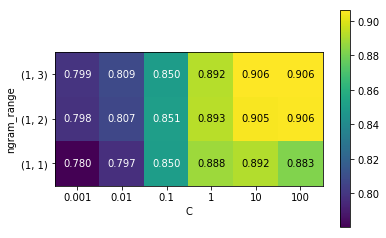

In [37]:
# extract scores from grid_search
scores = grid.cv_results_['mean_test_score'].reshape(-1, 3).T
# visualize heat map
heatmap = mglearn.tools.heatmap(
    scores, xlabel="C", ylabel="ngram_range", cmap="viridis", fmt="%.3f",
    xticklabels=param_grid['logisticregression__C'],
    yticklabels=param_grid['tfidfvectorizer__ngram_range'])
plt.colorbar(heatmap)

(-22, 22)

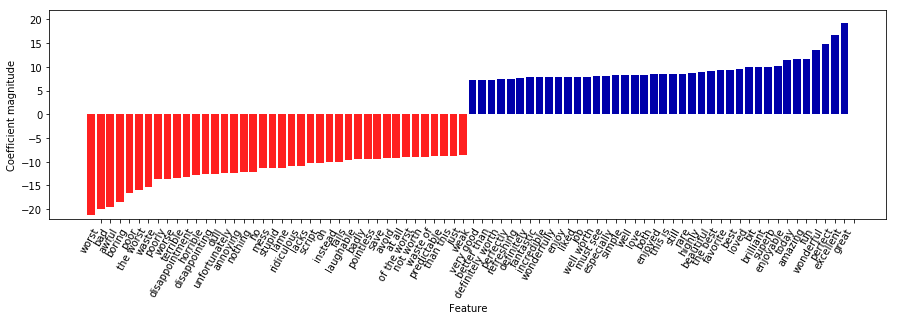

In [38]:
# extract feature names and coefficients
vect = grid.best_estimator_.named_steps['tfidfvectorizer']
feature_names = np.array(vect.get_feature_names())
coef = grid.best_estimator_.named_steps['logisticregression'].coef_
mglearn.tools.visualize_coefficients(coef, feature_names, n_top_features=40)
plt.ylim(-22, 22)

(-22, 22)

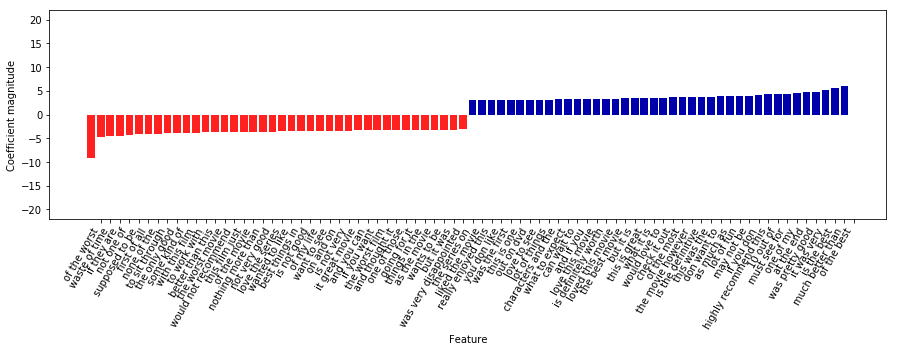

In [39]:
# find 3-gram features
mask = np.array([len(feature.split(" ")) for feature in feature_names]) == 3
# visualize only 3-gram features
mglearn.tools.visualize_coefficients(coef.ravel()[mask],
                                     feature_names[mask], n_top_features=40)
plt.ylim(-22, 22)

In [45]:
import spacy
import nltk

# load spacy's English-language models
en_nlp = spacy.load('en')
# instantiate nltk's Porter stemmer
stemmer = nltk.stem.PorterStemmer()

# define function to compare lemmatization in spacy with stemming in nltk
def compare_normalization(doc):
    # tokenize document in spacy
    doc_spacy = en_nlp(doc)
    # print lemmas found by spacy
    print("Lemmatization:")
    print([token.lemma_ for token in doc_spacy])
    # print tokens found by Porter stemmer
    print("Stemming:")
    print([stemmer.stem(token.norm_.lower()) for token in doc_spacy])

OSError: [E050] Can't find model 'en'. It doesn't seem to be a shortcut link, a Python package or a valid path to a data directory.

In [ ]:
compare_normalization(u"Our meeting today was worse than yesterday, "
                       "I'm scared of meeting the clients tomorrow.")